In [8]:
import numpy as np
np.random.seed(2016)

import sys
sys.path.append('/usr/local/lib/python2.7/site-packages')

import os
import glob
import cv2
import math
import pickle
import datetime
import pandas as pd
from scipy import misc
import numpy

from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D,Conv2D
from keras.layers import Concatenate
from keras.utils import np_utils
from keras.models import model_from_json
from sklearn.metrics import log_loss
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger

from keras import backend as K
K.set_image_dim_ordering('th')

from matplotlib import pyplot as plt #for imshow
from sklearn.feature_extraction import image #image patching

import warnings #turn-off warnings
warnings.filterwarnings("ignore")

#------- Parameters -------------#
global nb_classes
global img_rows
global img_cols
global channel

nb_classes = 3
img_rows, img_cols = 128,128 # input image dimensions (be resized to this!)
channel = 3

Read train images
Load folder c0
Load folder c1
Load folder c2
Read val images
Load folder c0
Load folder c1
Load folder c2
Read test images
Load folder test_c0
Load folder test_c1
Load folder test_c2


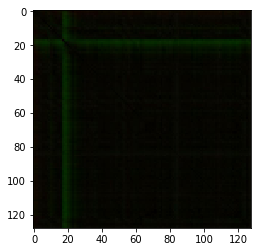

In [9]:
def get_im(path):
    # Load as grayscale
    img = misc.imread(path, mode='RGB')
    #img = cv2.imread(path, 0)
    # Reduce size
    resized = cv2.resize(img, (img_rows, img_cols))
    return resized


def load_train():
    X_train = []
    y_train = []
    print('Read train images')
    for j in range(0,nb_classes):
        print('Load folder c{}'.format(j))
        path = os.path.join('.', 'ts_imgs_color', 'train', str(j), '*.jpg')
        files = glob.glob(path)
        for fl in files:
            img = get_im(fl)
            X_train.append(img)
            y_train.append(j)

    return X_train, y_train

def load_val():
    X_val = []
    y_val = []
    print('Read val images')
    for j in range(0,nb_classes):
        print('Load folder c{}'.format(j))
        path = os.path.join('.', 'ts_imgs_color', 'val', str(j), '*.jpg')
        files = glob.glob(path)
        for fl in files:
            img = get_im(fl)
            X_val.append(img)
            y_val.append(j)

    return X_val, y_val

def load_test():
    X_test = []
    y_test = []
    print('Read test images')
    for j in range(0,nb_classes):
        print('Load folder test_c{}'.format(j))
        path = os.path.join('.', 'ts_imgs_color', 'test', str(j), '*.jpg')
        files = glob.glob(path)
        for fl in files:
            img = get_im(fl)
            X_test.append(img)
            y_test.append(j)

    return X_test, y_test

def cache_data(data, path):
    if os.path.isdir(os.path.dirname(path)):
        file = open(path, 'wb')
        pickle.dump(data, file)
        file.close()
    else:
        print('Directory doesnt exists')


def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data


cache_path = os.path.join('cache', 'train_full_color_128.dat')
if not os.path.isfile(cache_path):
    train_data, train_target = load_train()
    cache_data((train_data, train_target), cache_path)
else:
    print('Restore train from cache!')
    (train_data, train_target) = restore_data(cache_path)

cache_path = os.path.join('cache', 'val_full_color_128.dat')
if not os.path.isfile(cache_path):
    val_data, val_target = load_val()
    cache_data((val_data, val_target), cache_path)
else:
    print('Restore val from cache!')
    (val_data, val_target) = restore_data(cache_path)
    
cache_path = os.path.join('cache', 'test_full_color_128.dat')
if not os.path.isfile(cache_path):
    test_data, test_target = load_test()
    cache_data((test_data, test_target), cache_path)
else:
    print('Restore train from cache!')
    (test_data, test_target) = restore_data(cache_path)



train_data = np.array(train_data, dtype=np.uint8)
train_target = np.array(train_target, dtype=np.uint8)

val_data = np.array(val_data, dtype=np.uint8)
val_target = np.array(val_target, dtype=np.uint8)

test_data = np.array(test_data, dtype=np.uint8)
test_target = np.array(test_target, dtype=np.uint8)

# imshow
plt.imshow(train_data[0])
plt.pause(1)


#patches = image.extract_patches_2d(train_data[0], (50, 50)) # dense griding patches
#print(patches.shape)



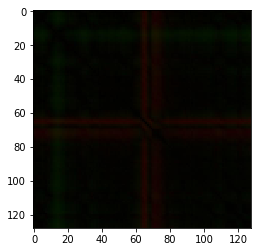

In [10]:
plt.imshow(val_data[21949])

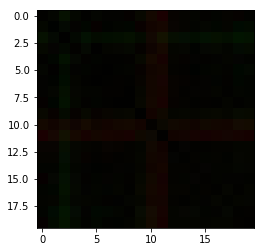

In [4]:
plt.imshow(val_data[21949])

In [25]:
sys.getsizeof(X_train)

1081503888

In [11]:
train_data = train_data.reshape(train_data.shape[0], channel, img_rows, img_cols)
train_target = np_utils.to_categorical(train_target, nb_classes)
train_data = train_data.astype('float32')
train_data /= 255
print('Train feat:', train_data.shape)
print('Train target:', train_target.shape)

val_data = val_data.reshape(val_data.shape[0], channel, img_rows, img_cols)
val_target = np_utils.to_categorical(val_target, nb_classes)
val_data = val_data.astype('float32')
val_data /= 255
print('Val feat:', val_data.shape)
print('Val target:', val_target.shape)

test_data = test_data.reshape(test_data.shape[0], channel, img_rows, img_cols)
test_target = np_utils.to_categorical(test_target, nb_classes)
test_data = test_data.astype('float32')
test_data /= 255

X_train = train_data
Y_train = train_target
X_val = val_data
Y_val = val_target
X_test = test_data
Y_test = test_target

Train feat: (88013, 3, 128, 128)
Train target: (88013, 3)
Val feat: (22003, 3, 128, 128)
Val target: (22003, 3)


Train on 88013 samples, validate on 22003 samples
Epoch 1/60
88013/88013 [==============================] - 129s 1ms/step - loss: 0.4711 - acc: 0.7794 - val_loss: 0.5143 - val_acc: 0.7332
Epoch 2/60
88013/88013 [==============================] - 128s 1ms/step - loss: 0.4132 - acc: 0.8141 - val_loss: 0.5899 - val_acc: 0.7075
Epoch 3/60
88013/88013 [==============================] - 128s 1ms/step - loss: 0.3993 - acc: 0.8233 - val_loss: 0.5105 - val_acc: 0.7445
Epoch 4/60
88013/88013 [==============================] - 128s 1ms/step - loss: 0.3898 - acc: 0.8284 - val_loss: 0.4252 - val_acc: 0.8030
Epoch 5/60
88013/88013 [==============================] - 128s 1ms/step - loss: 0.3851 - acc: 0.8315 - val_loss: 0.4344 - val_acc: 0.7961
Epoch 6/60
88013/88013 [==============================] - 129s 1ms/step - loss: 0.3813 - acc: 0.8333 - val_loss: 0.5522 - val_acc: 0.7359
Epoch 7/60
88013/88013 [==============================] - 128s 1ms/step - loss: 0.3784 - acc: 0.8362 - val_loss: 0.4911 - 

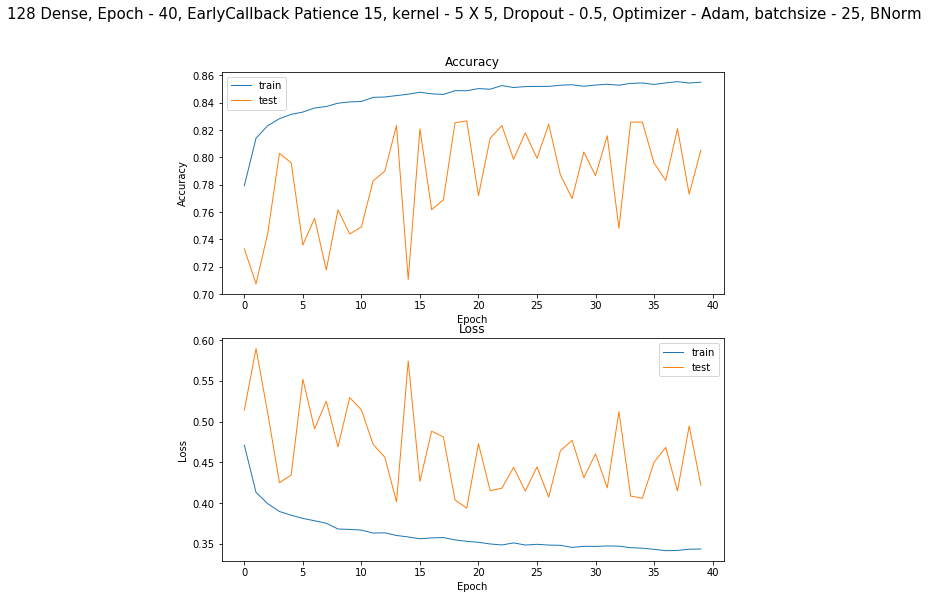

In [24]:
# 7. Define model architecture
model = Sequential()

model.add(Convolution2D(32, 5, 5, activation='relu', input_shape=(channel, img_rows, img_cols)))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Convolution2D(32, 5, 5, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128, activation='relu', kernel_initializer='uniform'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax',kernel_initializer='uniform'))
 
#opt = SGD(0.0025)
# 8. Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
# 9. Fit model on training data
cb = [EarlyStopping(monitor = 'val_loss', patience = 20)]
h = model.fit(X_train, Y_train, 
          batch_size=25, nb_epoch=60, verbose=1, validation_data = (X_val,Y_val),
             callbacks = cb)
 
# 10. Evaluate model on test data
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test accuarcy:', str(score))

# 11. Predicted labels
predictions = model.predict([X_test])
#print('Prediction shape:', predictions.shape)
#print("Prediction: %s" % str(predictions[0:5]))
#print("Target: %s" % str(Y_test[0:5]))  # only show first 2 probas

real_labels = np.argmax(Y_test, axis=1)
p_labels = np.argmax(predictions, axis=1)

print('Recognition Rate:', 100*float(sum(real_labels == p_labels))/float(len(p_labels)))

plt.figure(1, figsize=(9,9))
plt.suptitle('128 Dense, Epoch - 40, EarlyCallback Patience 15, kernel - 5 X 5, Dropout - 0.5, Optimizer - Adam, batchsize - 25, BNorm', fontsize = 15)
plt.subplot(211)  
plt.plot(h.history['acc'], linewidth = 1.0)  
plt.plot(h.history['val_acc'], linewidth = 1.0)  
plt.title('Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best') 

plt.subplot(212)  
plt.plot(h.history['loss'], linewidth = 1.0)  
plt.plot(h.history['val_loss'], linewidth = 1.0)  
plt.title('Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best')  
plt.show() 


In [25]:
def plot_filters(layer, x, y):
    print (layer.kernel)
    filters = K.get_value(layer.kernel)
    print (filters.shape)
    fig = plt.figure(figsize=(6,6))
    for j in range(32):
        ax = fig.add_subplot(y, x, j+1)  
        ax.matshow(filters[:,:,0,j]) #for 2nd layer, 3rd arg should also be variable! (caz its 3x3x32x32, not 3x3x1x32) 
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.tight_layout()
    plt.pause(15)
    return plt

visualize_filters = 0
if visualize_filters:
    plot_filters(model.layers[0], 8,4)
    plot_filters(model.layers[1], 8,4)

<tf.Variable 'conv2d_5/kernel:0' shape=(5, 5, 3, 32) dtype=float32_ref>
(5, 5, 3, 32)


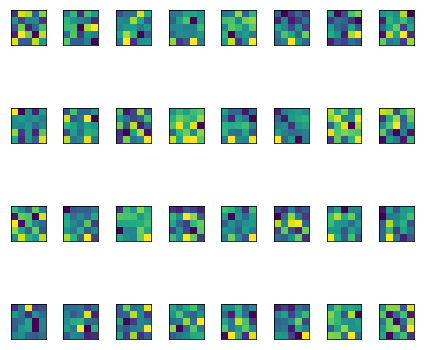

<module 'matplotlib.pyplot' from 'C:\\Python36\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [27]:
plot_filters(model.layers[0], 8,4)

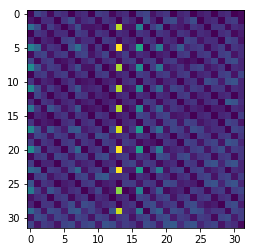

In [62]:
plt.imshow(X_train[0][2])

In [63]:
def load_newtest():
    X_newtest = []
    y_newtest = []
    print('Read new test images')
    for j in range(0,nb_classes):
        print('Load folder newtest_c{}'.format(j))
        path = os.path.join('.', 'ts_imgs_color', 'new_test_20k_color', str(j), '*.jpg')
        files = glob.glob(path)
        for fl in files:
            img = get_im(fl)
            X_newtest.append(img)
            y_newtest.append(j)
    return X_newtest, y_newtest
newtest_data, newtest_target = load_newtest()
newtest_data = np.array(newtest_data, dtype=np.uint8)
newtest_target = np.array(newtest_target, dtype=np.uint8)

newtest_data = newtest_data.reshape(newtest_data.shape[0], channel, img_rows, img_cols)
newtest_target = np_utils.to_categorical(newtest_target, nb_classes)
newtest_data = newtest_data.astype('float32')
newtest_data /= 255


X_newtest = newtest_data
Y_newtest = newtest_target

Read new test images
Load folder newtest_c0
Load folder newtest_c1
Load folder newtest_c2


In [64]:
newpredictions = model.predict([X_newtest])

In [65]:
p_labels = np.argmax(newpredictions, axis=1)
np.where(p_labels == 2)[0]

array([13092, 19584, 19640], dtype=int64)

In [78]:
dframe = pd.read_table('labels_20k.csv', sep='delimiter')

In [79]:
real_labels = np.argmax(dframe.values, axis=1)

In [80]:
len(real_labels)

20000

In [81]:
print('Recognition Rate:', 100*float(sum(real_labels == p_labels))/float(len(p_labels)))

Recognition Rate: 69.555


## Hidden Layer Neurons Tuning

Train on 88013 samples, validate on 22003 samples
Epoch 1/60
88013/88013 [==============================] - 130s 1ms/step - loss: 0.6968 - acc: 0.6747 - val_loss: 0.5795 - val_acc: 0.6747
Epoch 2/60
88013/88013 [==============================] - 129s 1ms/step - loss: 0.6025 - acc: 0.6747 - val_loss: 0.5793 - val_acc: 0.6747
Epoch 3/60
88013/88013 [==============================] - 126s 1ms/step - loss: 0.5983 - acc: 0.6747 - val_loss: 0.5485 - val_acc: 0.6747
Epoch 4/60
88013/88013 [==============================] - 126s 1ms/step - loss: 0.5940 - acc: 0.6747 - val_loss: 0.5557 - val_acc: 0.6747
Epoch 5/60
88013/88013 [==============================] - 127s 1ms/step - loss: 0.5905 - acc: 0.6747 - val_loss: 0.5562 - val_acc: 0.6747
Epoch 6/60
88013/88013 [==============================] - 126s 1ms/step - loss: 0.5889 - acc: 0.6747 - val_loss: 0.5519 - val_acc: 0.6747
Epoch 7/60
88013/88013 [==============================] - 127s 1ms/step - loss: 0.5883 - acc: 0.6747 - val_loss: 0.5800 - 

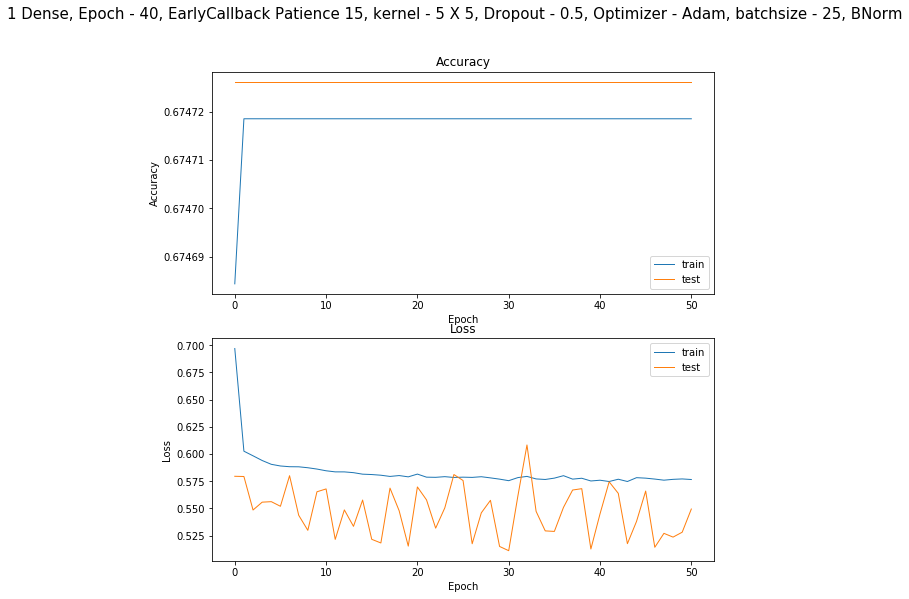

In [5]:
# 7. Define model architecture
model = Sequential()

model.add(Convolution2D(32, 5, 5, activation='relu', input_shape=(channel, img_rows, img_cols)))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Convolution2D(32, 5, 5, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1, activation='relu', kernel_initializer='uniform'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax',kernel_initializer='uniform'))
 
#opt = SGD(0.0025)
# 8. Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
# 9. Fit model on training data
cb = [EarlyStopping(monitor = 'val_loss', patience = 20)]
h = model.fit(X_train, Y_train, 
          batch_size=25, nb_epoch=60, verbose=1, validation_data = (X_val,Y_val),
             callbacks = cb)
 
# 10. Evaluate model on test data
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test accuarcy:', str(score))

# 11. Predicted labels
predictions = model.predict([X_test])
#print('Prediction shape:', predictions.shape)
#print("Prediction: %s" % str(predictions[0:5]))
#print("Target: %s" % str(Y_test[0:5]))  # only show first 2 probas

real_labels = np.argmax(Y_test, axis=1)
p_labels = np.argmax(predictions, axis=1)

print('Recognition Rate:', 100*float(sum(real_labels == p_labels))/float(len(p_labels)))

plt.figure(1, figsize=(9,9))
plt.suptitle('1 Dense, Epoch - 40, EarlyCallback Patience 15, kernel - 5 X 5, Dropout - 0.5, Optimizer - Adam, batchsize - 25, BNorm', fontsize = 15)
plt.subplot(211)  
plt.plot(h.history['acc'], linewidth = 1.0)  
plt.plot(h.history['val_acc'], linewidth = 1.0)  
plt.title('Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best') 

plt.subplot(212)  
plt.plot(h.history['loss'], linewidth = 1.0)  
plt.plot(h.history['val_loss'], linewidth = 1.0)  
plt.title('Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best')  
plt.show() 


Train on 88013 samples, validate on 22003 samples
Epoch 1/60
88013/88013 [==============================] - 127s 1ms/step - loss: 0.4803 - acc: 0.7762 - val_loss: 0.4594 - val_acc: 0.7881
Epoch 2/60
88013/88013 [==============================] - 127s 1ms/step - loss: 0.4263 - acc: 0.8074 - val_loss: 0.4327 - val_acc: 0.7985
Epoch 3/60
88013/88013 [==============================] - 127s 1ms/step - loss: 0.4102 - acc: 0.8185 - val_loss: 0.4813 - val_acc: 0.7640
Epoch 4/60
88013/88013 [==============================] - 127s 1ms/step - loss: 0.4015 - acc: 0.8233 - val_loss: 0.4729 - val_acc: 0.7597
Epoch 5/60
88013/88013 [==============================] - 128s 1ms/step - loss: 0.3949 - acc: 0.8268 - val_loss: 0.4976 - val_acc: 0.7265
Epoch 6/60
88013/88013 [==============================] - 127s 1ms/step - loss: 0.3920 - acc: 0.8293 - val_loss: 0.5639 - val_acc: 0.7139
Epoch 7/60
88013/88013 [==============================] - 127s 1ms/step - loss: 0.3888 - acc: 0.8313 - val_loss: 0.5417 - 

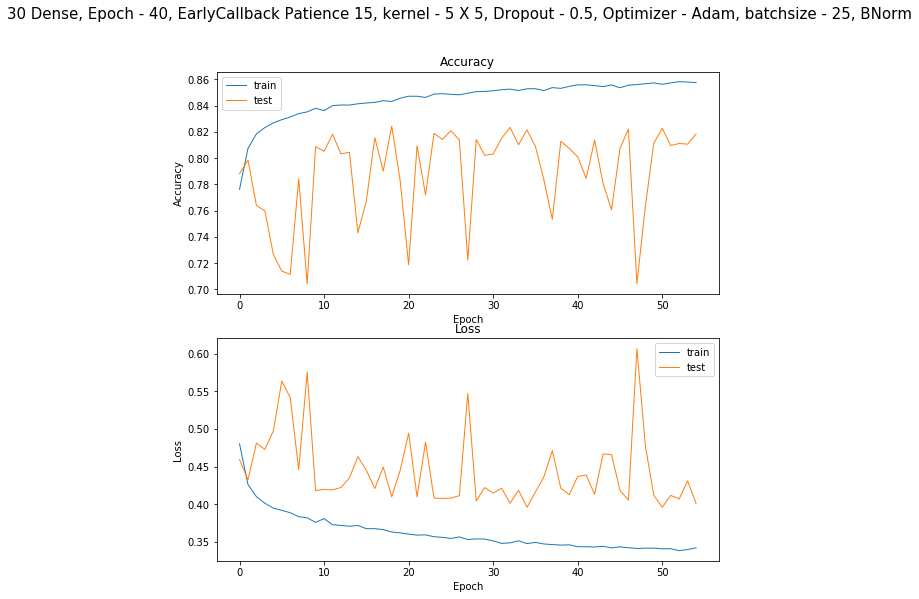

In [6]:
# 7. Define model architecture
model = Sequential()

model.add(Convolution2D(32, 5, 5, activation='relu', input_shape=(channel, img_rows, img_cols)))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Convolution2D(32, 5, 5, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(40, activation='relu', kernel_initializer='uniform'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax',kernel_initializer='uniform'))
 
#opt = SGD(0.0025)
# 8. Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
# 9. Fit model on training data
cb = [EarlyStopping(monitor = 'val_loss', patience = 20)]
h = model.fit(X_train, Y_train, 
          batch_size=25, nb_epoch=60, verbose=1, validation_data = (X_val,Y_val),
             callbacks = cb)
 
# 10. Evaluate model on test data
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test accuarcy:', str(score))

# 11. Predicted labels
predictions = model.predict([X_test])
#print('Prediction shape:', predictions.shape)
#print("Prediction: %s" % str(predictions[0:5]))
#print("Target: %s" % str(Y_test[0:5]))  # only show first 2 probas

real_labels = np.argmax(Y_test, axis=1)
p_labels = np.argmax(predictions, axis=1)

print('Recognition Rate:', 100*float(sum(real_labels == p_labels))/float(len(p_labels)))

plt.figure(1, figsize=(9,9))
plt.suptitle('30 Dense, Epoch - 40, EarlyCallback Patience 15, kernel - 5 X 5, Dropout - 0.5, Optimizer - Adam, batchsize - 25, BNorm', fontsize = 15)
plt.subplot(211)  
plt.plot(h.history['acc'], linewidth = 1.0)  
plt.plot(h.history['val_acc'], linewidth = 1.0)  
plt.title('Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best') 

plt.subplot(212)  
plt.plot(h.history['loss'], linewidth = 1.0)  
plt.plot(h.history['val_loss'], linewidth = 1.0)  
plt.title('Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best')  
plt.show() 


Train on 88013 samples, validate on 22003 samples
Epoch 1/60
88013/88013 [==============================] - 128s 1ms/step - loss: 0.4675 - acc: 0.7803 - val_loss: 0.4310 - val_acc: 0.8081
Epoch 2/60
88013/88013 [==============================] - 127s 1ms/step - loss: 0.4141 - acc: 0.8150 - val_loss: 0.4304 - val_acc: 0.8026
Epoch 3/60
88013/88013 [==============================] - 127s 1ms/step - loss: 0.4017 - acc: 0.8241 - val_loss: 0.4491 - val_acc: 0.7866
Epoch 4/60
88013/88013 [==============================] - 127s 1ms/step - loss: 0.3940 - acc: 0.8278 - val_loss: 0.4624 - val_acc: 0.7572
Epoch 5/60
88013/88013 [==============================] - 127s 1ms/step - loss: 0.3898 - acc: 0.8314 - val_loss: 0.4209 - val_acc: 0.8141
Epoch 6/60
88013/88013 [==============================] - 129s 1ms/step - loss: 0.3852 - acc: 0.8329 - val_loss: 0.4273 - val_acc: 0.8035
Epoch 7/60
88013/88013 [==============================] - 127s 1ms/step - loss: 0.3794 - acc: 0.8364 - val_loss: 0.4568 - 

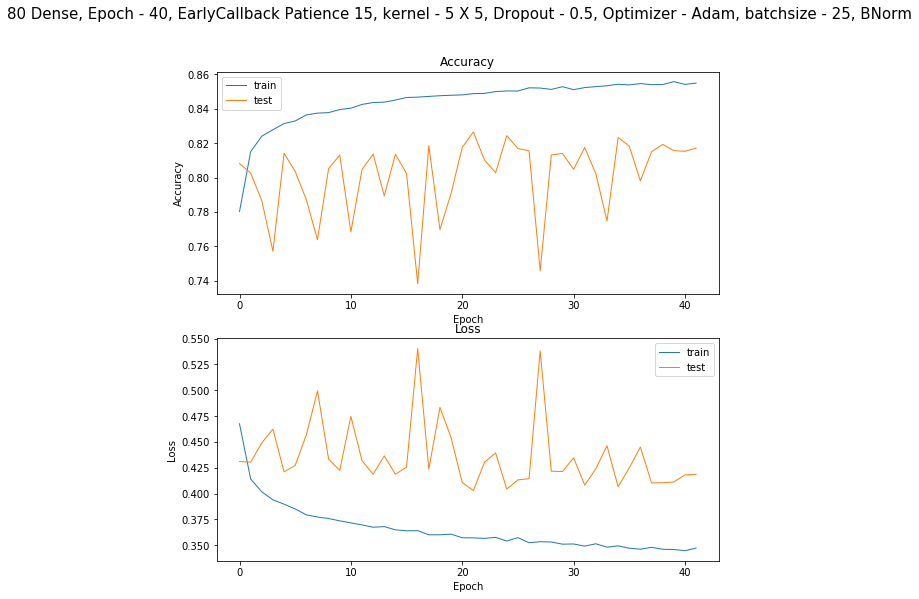

In [7]:
# 7. Define model architecture
model = Sequential()

model.add(Convolution2D(32, 5, 5, activation='relu', input_shape=(channel, img_rows, img_cols)))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Convolution2D(32, 5, 5, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(80, activation='relu', kernel_initializer='uniform'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax',kernel_initializer='uniform'))
 
#opt = SGD(0.0025)
# 8. Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
# 9. Fit model on training data
cb = [EarlyStopping(monitor = 'val_loss', patience = 20)]
h = model.fit(X_train, Y_train, 
          batch_size=25, nb_epoch=60, verbose=1, validation_data = (X_val,Y_val),
             callbacks = cb)
 
# 10. Evaluate model on test data
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test accuarcy:', str(score))

# 11. Predicted labels
predictions = model.predict([X_test])
#print('Prediction shape:', predictions.shape)
#print("Prediction: %s" % str(predictions[0:5]))
#print("Target: %s" % str(Y_test[0:5]))  # only show first 2 probas

real_labels = np.argmax(Y_test, axis=1)
p_labels = np.argmax(predictions, axis=1)

print('Recognition Rate:', 100*float(sum(real_labels == p_labels))/float(len(p_labels)))

plt.figure(1, figsize=(9,9))
plt.suptitle('80 Dense, Epoch - 40, EarlyCallback Patience 15, kernel - 5 X 5, Dropout - 0.5, Optimizer - Adam, batchsize - 25, BNorm', fontsize = 15)
plt.subplot(211)  
plt.plot(h.history['acc'], linewidth = 1.0)  
plt.plot(h.history['val_acc'], linewidth = 1.0)  
plt.title('Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best') 

plt.subplot(212)  
plt.plot(h.history['loss'], linewidth = 1.0)  
plt.plot(h.history['val_loss'], linewidth = 1.0)  
plt.title('Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best')  
plt.show() 


Train on 88013 samples, validate on 22003 samples
Epoch 1/60
88013/88013 [==============================] - 128s 1ms/step - loss: 0.4683 - acc: 0.7808 - val_loss: 0.4610 - val_acc: 0.7812
Epoch 2/60
88013/88013 [==============================] - 128s 1ms/step - loss: 0.4131 - acc: 0.8138 - val_loss: 0.5259 - val_acc: 0.7060
Epoch 3/60
88013/88013 [==============================] - 128s 1ms/step - loss: 0.4002 - acc: 0.8222 - val_loss: 0.4620 - val_acc: 0.7734
Epoch 4/60
88013/88013 [==============================] - 128s 1ms/step - loss: 0.3905 - acc: 0.8288 - val_loss: 0.8128 - val_acc: 0.5795
Epoch 5/60
88013/88013 [==============================] - 128s 1ms/step - loss: 0.3835 - acc: 0.8316 - val_loss: 0.4832 - val_acc: 0.7256
Epoch 6/60
88013/88013 [==============================] - 129s 1ms/step - loss: 0.3799 - acc: 0.8341 - val_loss: 0.4766 - val_acc: 0.7793
Epoch 7/60
88013/88013 [==============================] - 128s 1ms/step - loss: 0.3788 - acc: 0.8366 - val_loss: 0.4203 - 

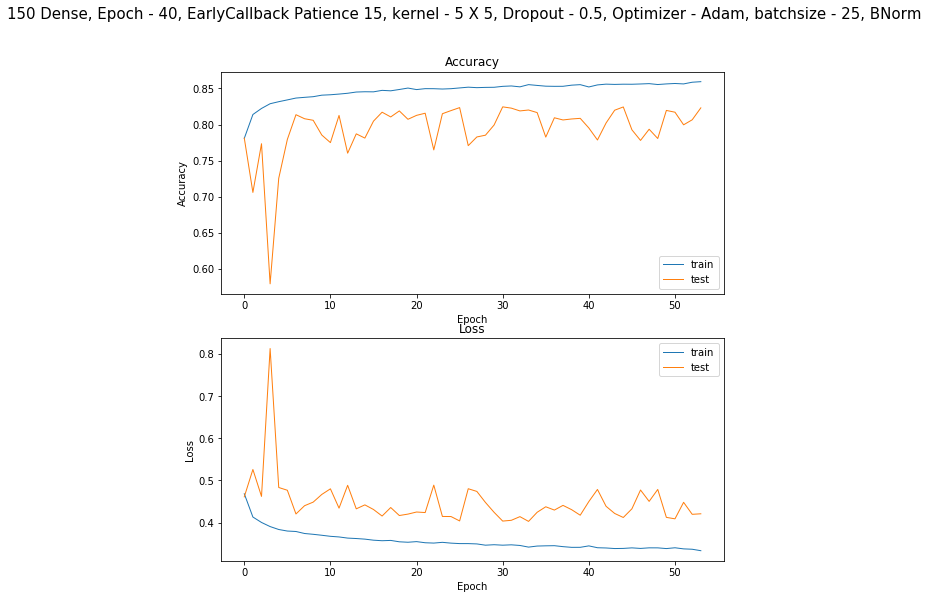

In [8]:
# 7. Define model architecture
model = Sequential()

model.add(Convolution2D(32, 5, 5, activation='relu', input_shape=(channel, img_rows, img_cols)))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Convolution2D(32, 5, 5, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(150, activation='relu', kernel_initializer='uniform'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax',kernel_initializer='uniform'))
 
#opt = SGD(0.0025)
# 8. Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
# 9. Fit model on training data
cb = [EarlyStopping(monitor = 'val_loss', patience = 20)]
h = model.fit(X_train, Y_train, 
          batch_size=25, nb_epoch=60, verbose=1, validation_data = (X_val,Y_val),
             callbacks = cb)
 
# 10. Evaluate model on test data
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test accuarcy:', str(score))

# 11. Predicted labels
predictions = model.predict([X_test])
#print('Prediction shape:', predictions.shape)
#print("Prediction: %s" % str(predictions[0:5]))
#print("Target: %s" % str(Y_test[0:5]))  # only show first 2 probas

real_labels = np.argmax(Y_test, axis=1)
p_labels = np.argmax(predictions, axis=1)

print('Recognition Rate:', 100*float(sum(real_labels == p_labels))/float(len(p_labels)))

plt.figure(1, figsize=(9,9))
plt.suptitle('150 Dense, Epoch - 40, EarlyCallback Patience 15, kernel - 5 X 5, Dropout - 0.5, Optimizer - Adam, batchsize - 25, BNorm', fontsize = 15)
plt.subplot(211)  
plt.plot(h.history['acc'], linewidth = 1.0)  
plt.plot(h.history['val_acc'], linewidth = 1.0)  
plt.title('Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best') 

plt.subplot(212)  
plt.plot(h.history['loss'], linewidth = 1.0)  
plt.plot(h.history['val_loss'], linewidth = 1.0)  
plt.title('Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best')  
plt.show() 


Train on 88013 samples, validate on 22003 samples
Epoch 1/60
88013/88013 [==============================] - 129s 1ms/step - loss: 0.4668 - acc: 0.7782 - val_loss: 0.4899 - val_acc: 0.7556
Epoch 2/60
88013/88013 [==============================] - 129s 1ms/step - loss: 0.4105 - acc: 0.8150 - val_loss: 0.4216 - val_acc: 0.8071
Epoch 3/60
88013/88013 [==============================] - 129s 1ms/step - loss: 0.3939 - acc: 0.8231 - val_loss: 0.5592 - val_acc: 0.7109
Epoch 4/60
88013/88013 [==============================] - 129s 1ms/step - loss: 0.3819 - acc: 0.8318 - val_loss: 0.4201 - val_acc: 0.8099
Epoch 5/60
88013/88013 [==============================] - 129s 1ms/step - loss: 0.3786 - acc: 0.8343 - val_loss: 0.4769 - val_acc: 0.7758
Epoch 6/60
88013/88013 [==============================] - 129s 1ms/step - loss: 0.3735 - acc: 0.8366 - val_loss: 0.4512 - val_acc: 0.7657
Epoch 7/60
88013/88013 [==============================] - 130s 1ms/step - loss: 0.3692 - acc: 0.8403 - val_loss: 0.4809 - 

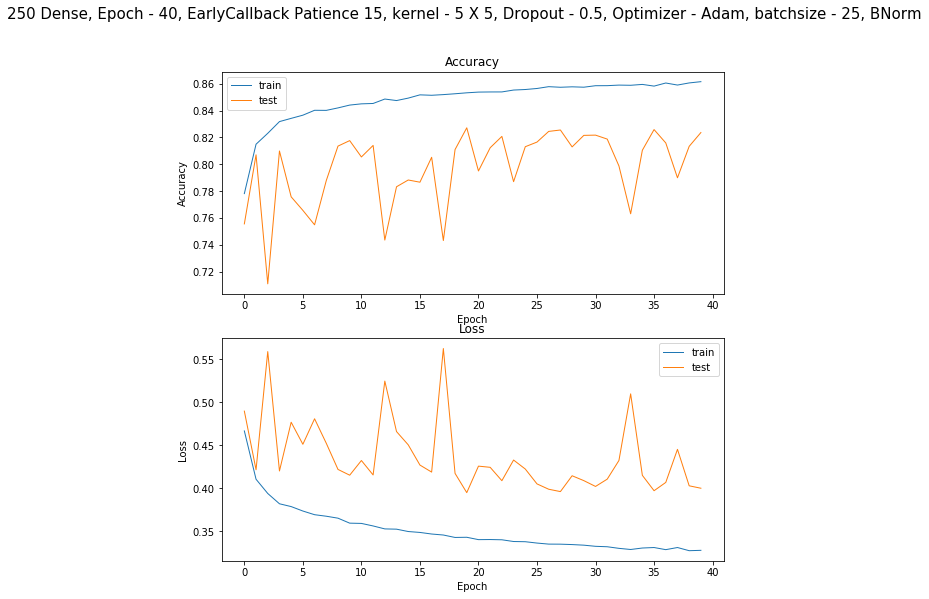

In [9]:
# 7. Define model architecture
model = Sequential()

model.add(Convolution2D(32, 5, 5, activation='relu', input_shape=(channel, img_rows, img_cols)))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Convolution2D(32, 5, 5, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(250, activation='relu', kernel_initializer='uniform'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax',kernel_initializer='uniform'))
 
#opt = SGD(0.0025)
# 8. Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
# 9. Fit model on training data
cb = [EarlyStopping(monitor = 'val_loss', patience = 20)]
h = model.fit(X_train, Y_train, 
          batch_size=25, nb_epoch=60, verbose=1, validation_data = (X_val,Y_val),
             callbacks = cb)
 
# 10. Evaluate model on test data
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test accuarcy:', str(score))

# 11. Predicted labels
predictions = model.predict([X_test])
#print('Prediction shape:', predictions.shape)
#print("Prediction: %s" % str(predictions[0:5]))
#print("Target: %s" % str(Y_test[0:5]))  # only show first 2 probas

real_labels = np.argmax(Y_test, axis=1)
p_labels = np.argmax(predictions, axis=1)

print('Recognition Rate:', 100*float(sum(real_labels == p_labels))/float(len(p_labels)))

plt.figure(1, figsize=(9,9))
plt.suptitle('250 Dense, Epoch - 40, EarlyCallback Patience 15, kernel - 5 X 5, Dropout - 0.5, Optimizer - Adam, batchsize - 25, BNorm', fontsize = 15)
plt.subplot(211)  
plt.plot(h.history['acc'], linewidth = 1.0)  
plt.plot(h.history['val_acc'], linewidth = 1.0)  
plt.title('Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best') 

plt.subplot(212)  
plt.plot(h.history['loss'], linewidth = 1.0)  
plt.plot(h.history['val_loss'], linewidth = 1.0)  
plt.title('Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best')  
plt.show() 


Train on 88013 samples, validate on 22003 samples
Epoch 1/60
88013/88013 [==============================] - 131s 1ms/step - loss: 0.4693 - acc: 0.7776 - val_loss: 0.4952 - val_acc: 0.7449
Epoch 2/60
88013/88013 [==============================] - 130s 1ms/step - loss: 0.4154 - acc: 0.8125 - val_loss: 0.6699 - val_acc: 0.6793
Epoch 3/60
88013/88013 [==============================] - 130s 1ms/step - loss: 0.4014 - acc: 0.8210 - val_loss: 0.4526 - val_acc: 0.8014
Epoch 4/60
88013/88013 [==============================] - 131s 1ms/step - loss: 0.3954 - acc: 0.8259 - val_loss: 0.4286 - val_acc: 0.8085
Epoch 5/60
88013/88013 [==============================] - 130s 1ms/step - loss: 0.3884 - acc: 0.8277 - val_loss: 0.4276 - val_acc: 0.8047
Epoch 6/60
88013/88013 [==============================] - 130s 1ms/step - loss: 0.3851 - acc: 0.8295 - val_loss: 0.4653 - val_acc: 0.7909
Epoch 7/60
88013/88013 [==============================] - 130s 1ms/step - loss: 0.3811 - acc: 0.8321 - val_loss: 0.4327 - 

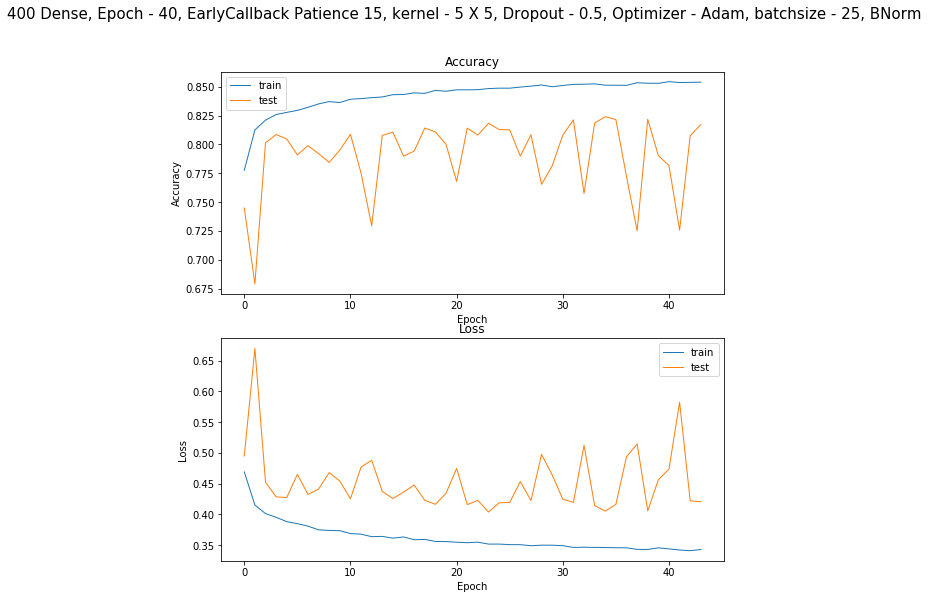

In [11]:
# 7. Define model architecture
model = Sequential()

model.add(Convolution2D(32, 5, 5, activation='relu', input_shape=(channel, img_rows, img_cols)))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Convolution2D(32, 5, 5, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512, activation='relu', kernel_initializer='uniform'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax',kernel_initializer='uniform'))
 
#opt = SGD(0.0025)
# 8. Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
# 9. Fit model on training data
cb = [EarlyStopping(monitor = 'val_loss', patience = 20)]
h = model.fit(X_train, Y_train, 
          batch_size=25, nb_epoch=60, verbose=1, validation_data = (X_val,Y_val),
             callbacks = cb)
 
# 10. Evaluate model on test data
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test accuarcy:', str(score))

# 11. Predicted labels
predictions = model.predict([X_test])
#print('Prediction shape:', predictions.shape)
#print("Prediction: %s" % str(predictions[0:5]))
#print("Target: %s" % str(Y_test[0:5]))  # only show first 2 probas

real_labels = np.argmax(Y_test, axis=1)
p_labels = np.argmax(predictions, axis=1)

print('Recognition Rate:', 100*float(sum(real_labels == p_labels))/float(len(p_labels)))

plt.figure(1, figsize=(9,9))
plt.suptitle('400 Dense, Epoch - 40, EarlyCallback Patience 15, kernel - 5 X 5, Dropout - 0.5, Optimizer - Adam, batchsize - 25, BNorm', fontsize = 15)
plt.subplot(211)  
plt.plot(h.history['acc'], linewidth = 1.0)  
plt.plot(h.history['val_acc'], linewidth = 1.0)  
plt.title('Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best') 

plt.subplot(212)  
plt.plot(h.history['loss'], linewidth = 1.0)  
plt.plot(h.history['val_loss'], linewidth = 1.0)  
plt.title('Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best')  
plt.show() 


## 16X16 images

Train on 88013 samples, validate on 22003 samples
Epoch 1/60
88013/88013 [==============================] - 35s 397us/step - loss: 0.5512 - acc: 0.7174 - val_loss: 0.5398 - val_acc: 0.7173
Epoch 2/60
88013/88013 [==============================] - 34s 391us/step - loss: 0.5199 - acc: 0.7414 - val_loss: 0.5358 - val_acc: 0.7302
Epoch 3/60
88013/88013 [==============================] - 34s 391us/step - loss: 0.5095 - acc: 0.7528 - val_loss: 0.5659 - val_acc: 0.7015
Epoch 4/60
88013/88013 [==============================] - 34s 382us/step - loss: 0.4998 - acc: 0.7604 - val_loss: 0.6469 - val_acc: 0.6361
Epoch 5/60
88013/88013 [==============================] - 33s 380us/step - loss: 0.4956 - acc: 0.7630 - val_loss: 0.5246 - val_acc: 0.7345
Epoch 6/60
88013/88013 [==============================] - 34s 381us/step - loss: 0.4925 - acc: 0.7666 - val_loss: 0.5346 - val_acc: 0.7128
Epoch 7/60
88013/88013 [==============================] - 34s 381us/step - loss: 0.4890 - acc: 0.7686 - val_loss: 0.

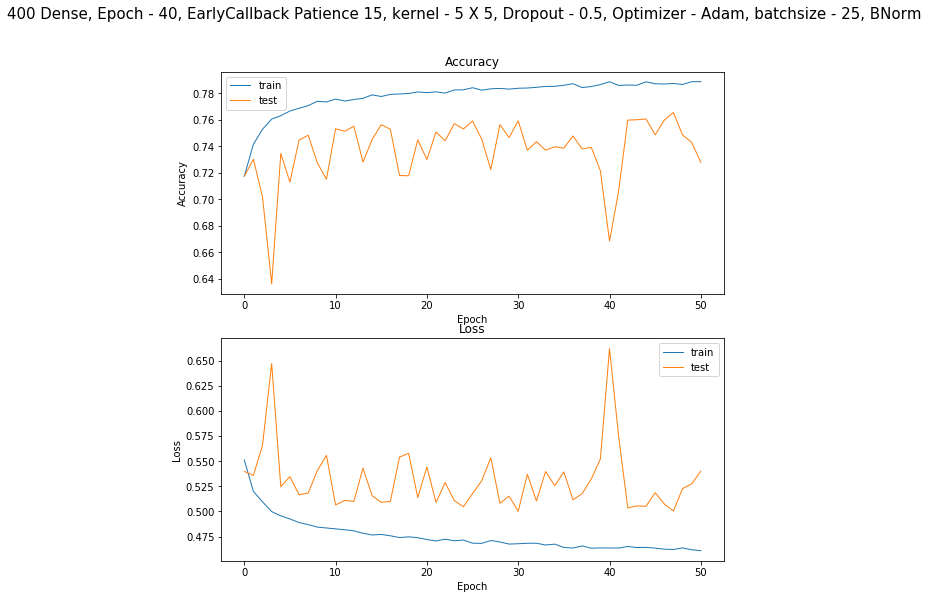

In [15]:
# 7. Define model architecture
model = Sequential()

model.add(Convolution2D(32, 2,2, activation='relu', input_shape=(channel, img_rows, img_cols)))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Convolution2D(32, 2, 2, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(350, activation='relu', kernel_initializer='uniform'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax',kernel_initializer='uniform'))
 
#opt = SGD(0.0025)
# 8. Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
# 9. Fit model on training data
cb = [EarlyStopping(monitor = 'val_loss', patience = 20)]
h = model.fit(X_train, Y_train, 
          batch_size=25, nb_epoch=60, verbose=1, validation_data = (X_val,Y_val),
             callbacks = cb)
 
# 10. Evaluate model on test data
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test accuarcy:', str(score))

# 11. Predicted labels
predictions = model.predict([X_test])
#print('Prediction shape:', predictions.shape)
#print("Prediction: %s" % str(predictions[0:5]))
#print("Target: %s" % str(Y_test[0:5]))  # only show first 2 probas

real_labels = np.argmax(Y_test, axis=1)
p_labels = np.argmax(predictions, axis=1)

print('Recognition Rate:', 100*float(sum(real_labels == p_labels))/float(len(p_labels)))

plt.figure(1, figsize=(9,9))
plt.suptitle('400 Dense, Epoch - 40, EarlyCallback Patience 15, kernel - 5 X 5, Dropout - 0.5, Optimizer - Adam, batchsize - 25, BNorm', fontsize = 15)
plt.subplot(211)  
plt.plot(h.history['acc'], linewidth = 1.0)  
plt.plot(h.history['val_acc'], linewidth = 1.0)  
plt.title('Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best') 

plt.subplot(212)  
plt.plot(h.history['loss'], linewidth = 1.0)  
plt.plot(h.history['val_loss'], linewidth = 1.0)  
plt.title('Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best')  
plt.show() 


## 20 X 20 Images

Train on 88013 samples, validate on 22003 samples
Epoch 1/60
88013/88013 [==============================] - 52s 596us/step - loss: 0.5548 - acc: 0.7155 - val_loss: 0.5689 - val_acc: 0.6776
Epoch 2/60
88013/88013 [==============================] - 52s 590us/step - loss: 0.5142 - acc: 0.7449 - val_loss: 0.5881 - val_acc: 0.6780
Epoch 3/60
88013/88013 [==============================] - 52s 594us/step - loss: 0.5080 - acc: 0.7494 - val_loss: 0.5365 - val_acc: 0.7200
Epoch 4/60
88013/88013 [==============================] - 52s 595us/step - loss: 0.4979 - acc: 0.7579 - val_loss: 0.5225 - val_acc: 0.7349
Epoch 5/60
88013/88013 [==============================] - 53s 597us/step - loss: 0.4948 - acc: 0.7595 - val_loss: 0.5225 - val_acc: 0.7359
Epoch 6/60
88013/88013 [==============================] - 52s 596us/step - loss: 0.4901 - acc: 0.7649 - val_loss: 0.5880 - val_acc: 0.6804
Epoch 7/60
88013/88013 [==============================] - 53s 597us/step - loss: 0.4870 - acc: 0.7660 - val_loss: 0.

88013/88013 [==============================] - 52s 592us/step - loss: 0.4548 - acc: 0.7907 - val_loss: 0.6241 - val_acc: 0.6782
Epoch 60/60
88013/88013 [==============================] - 52s 593us/step - loss: 0.4553 - acc: 0.7910 - val_loss: 0.5060 - val_acc: 0.7514
Test accuarcy: [0.7367291383406255, 0.7369928010471204]
Recognition Rate: 73.69928010471205


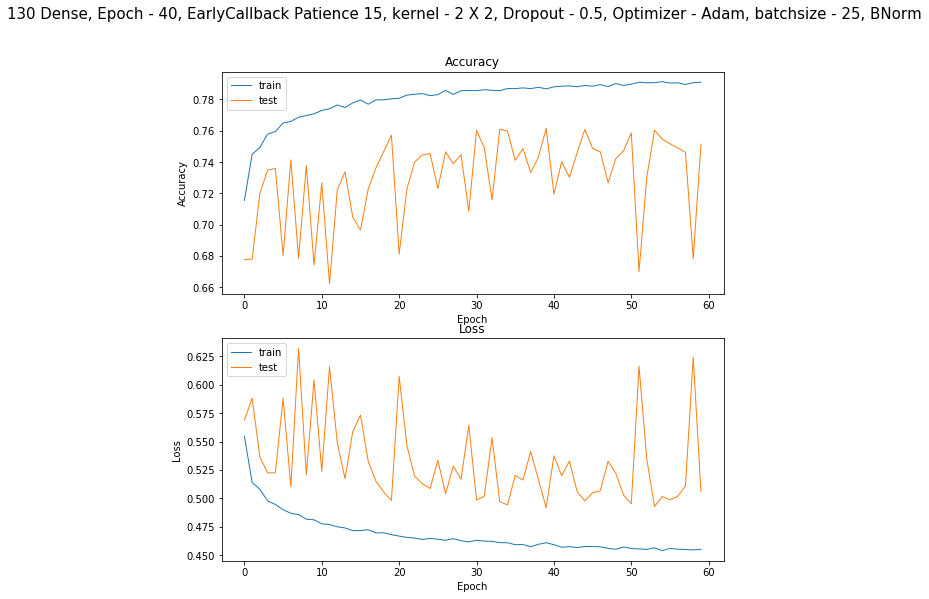

In [6]:
# 7. Define model architecture
model = Sequential()

model.add(Convolution2D(32, 2,2, activation='relu', input_shape=(channel, img_rows, img_cols)))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Convolution2D(32, 2, 2, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(130, activation='relu', kernel_initializer='uniform'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax',kernel_initializer='uniform'))
 
#opt = SGD(0.0025)
# 8. Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
# 9. Fit model on training data
cb = [EarlyStopping(monitor = 'val_loss', patience = 20)]

csv_logger = CSVLogger('log128.csv', append=True, separator=';')
h = model.fit(X_train, Y_train, 
          batch_size=25, nb_epoch=60, verbose=1, validation_data = (X_val,Y_val),
             callbacks = [cv, csv_logger])
 
# 10. Evaluate model on test data
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test accuarcy:', str(score))

# 11. Predicted labels
predictions = model.predict([X_test])
#print('Prediction shape:', predictions.shape)
#print("Prediction: %s" % str(predictions[0:5]))
#print("Target: %s" % str(Y_test[0:5]))  # only show first 2 probas

real_labels = np.argmax(Y_test, axis=1)
p_labels = np.argmax(predictions, axis=1)

print('Recognition Rate:', 100*float(sum(real_labels == p_labels))/float(len(p_labels)))

plt.figure(1, figsize=(9,9))
plt.suptitle('130 Dense, Epoch - 40, EarlyCallback Patience 15, kernel - 2 X 2, Dropout - 0.5, Optimizer - Adam, batchsize - 25, BNorm', fontsize = 15)
plt.subplot(211)  
plt.plot(h.history['acc'], linewidth = 1.0)  
plt.plot(h.history['val_acc'], linewidth = 1.0)  
plt.title('Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best') 

plt.subplot(212)  
plt.plot(h.history['loss'], linewidth = 1.0)  
plt.plot(h.history['val_loss'], linewidth = 1.0)  
plt.title('Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best')  
plt.show() 


## 128 X 128

Train on 88013 samples, validate on 22003 samples
Epoch 1/100
88013/88013 [==============================] - 4749s 54ms/step - loss: 0.4497 - acc: 0.7961 - val_loss: 0.7155 - val_acc: 0.6957
Epoch 2/100
88013/88013 [==============================] - 4731s 54ms/step - loss: 0.4111 - acc: 0.8269 - val_loss: 0.5746 - val_acc: 0.6857
Epoch 3/100
88013/88013 [==============================] - 4721s 54ms/step - loss: 0.3902 - acc: 0.8344 - val_loss: 0.5334 - val_acc: 0.7155
Epoch 4/100
88013/88013 [==============================] - 4721s 54ms/step - loss: 0.3840 - acc: 0.8387 - val_loss: 0.4413 - val_acc: 0.8050
Epoch 5/100
88013/88013 [==============================] - 4720s 54ms/step - loss: 0.3793 - acc: 0.8394 - val_loss: 0.4162 - val_acc: 0.8250
Epoch 6/100
88013/88013 [==============================] - 4724s 54ms/step - loss: 0.3710 - acc: 0.8435 - val_loss: 0.4771 - val_acc: 0.7843
Epoch 7/100
88013/88013 [==============================] - 4726s 54ms/step - loss: 0.3667 - acc: 0.8454 

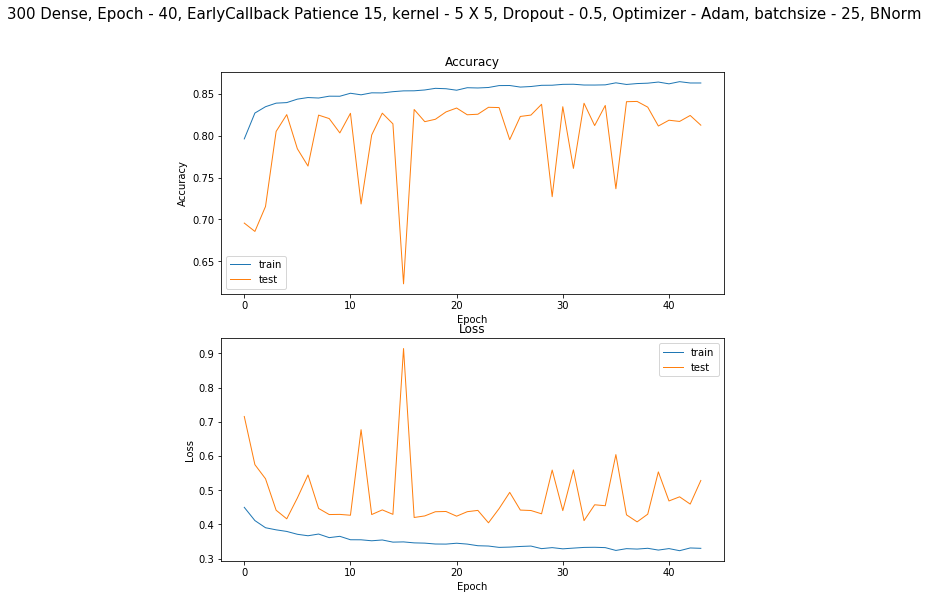

In [15]:
# 7. Define model architecture
model = Sequential()

model.add(Convolution2D(64, 5,5, activation='relu', input_shape=(channel, img_rows, img_cols)))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Convolution2D(64, 5,5, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(300, activation='relu', kernel_initializer='uniform'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax',kernel_initializer='uniform'))
 
#opt = SGD(0.0025)
# 8. Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
# 9. Fit model on training data
cb = [EarlyStopping(monitor = 'val_loss', patience = 20), CSVLogger('log128.csv', append=True, separator=';')]

h = model.fit(X_train, Y_train, 
          batch_size=25, nb_epoch=100, verbose=1, validation_data = (X_val,Y_val),
             callbacks = cb)
 
# 10. Evaluate model on test data
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test accuarcy:', str(score))

# 11. Predicted labels
predictions = model.predict([X_test])
#print('Prediction shape:', predictions.shape)
#print("Prediction: %s" % str(predictions[0:5]))
#print("Target: %s" % str(Y_test[0:5]))  # only show first 2 probas

real_labels = np.argmax(Y_test, axis=1)
p_labels = np.argmax(predictions, axis=1)

print('Recognition Rate:', 100*float(sum(real_labels == p_labels))/float(len(p_labels)))

plt.figure(1, figsize=(9,9))
plt.suptitle('300 Dense, Epoch - 40, EarlyCallback Patience 15, kernel - 5 X 5, Dropout - 0.5, Optimizer - Adam, batchsize - 25, BNorm', fontsize = 15)
plt.subplot(211)  
plt.plot(h.history['acc'], linewidth = 1.0)  
plt.plot(h.history['val_acc'], linewidth = 1.0)  
plt.title('Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best') 

plt.subplot(212)  
plt.plot(h.history['loss'], linewidth = 1.0)  
plt.plot(h.history['val_loss'], linewidth = 1.0)  
plt.title('Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best')  
plt.show() 


In [16]:
predictions

array([[7.9725045e-01, 2.0206651e-01, 6.8300415e-04],
       [6.8556976e-01, 3.1443024e-01, 2.7757360e-25],
       [4.2342442e-01, 5.7657564e-01, 0.0000000e+00],
       ...,
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [26]:
np.set_printoptions(threshold=np.nan)

In [40]:
predictions

array([[7.97250450e-01, 2.02066511e-01, 6.83004153e-04],
       [6.85569763e-01, 3.14430237e-01, 2.77573602e-25],
       [4.23424423e-01, 5.76575637e-01, 0.00000000e+00],
       [7.23007679e-01, 2.76082933e-01, 9.09374852e-04],
       [9.37046409e-01, 6.29272237e-02, 2.63353468e-05],
       [5.02300084e-01, 4.97699946e-01, 0.00000000e+00],
       [1.00000000e+00, 2.31242803e-09, 0.00000000e+00],
       [6.05108142e-01, 3.94891858e-01, 1.63623666e-38],
       [2.71933347e-01, 7.28066683e-01, 0.00000000e+00],
       [4.00407314e-01, 5.99592686e-01, 0.00000000e+00],
       [8.45253646e-01, 1.54746339e-01, 1.83771087e-09],
       [9.35223937e-01, 6.47760630e-02, 0.00000000e+00],
       [9.91263390e-01, 8.73665418e-03, 9.60622640e-12],
       [7.66032577e-01, 2.33275577e-01, 6.91861031e-04],
       [9.86145794e-01, 1.38541590e-02, 1.77930573e-10],
       [4.88816619e-01, 5.11183441e-01, 0.00000000e+00],
       [7.04417527e-01, 2.95582324e-01, 1.39558665e-07],
       [7.74681687e-01, 2.24519

In [49]:
np.median(predictions[2])

0.42342442

In [50]:
predictions[1]

array([6.8556976e-01, 3.1443024e-01, 2.7757360e-25], dtype=float32)